In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/AnruthaKamal/Market-Mix-Modelling-/main/Advertising.csv')

# EDA 

In [ ]:
df.head()

,Week,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


<h2> Checking for NULL values and data types of variables </h2>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Week       200 non-null    int64  
 1   TV         200 non-null    float64
 2   radio      200 non-null    float64
 3   newspaper  200 non-null    float64
 4   sales      200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


### Inference: 
  1. No Null Values in any of the columns
  2. All columns are of numbers


<h2> Statistical Summary of the dataset </h2>

In [ ]:
df.describe()

,Week,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


### Inference:
  1. Average expenses for Advertisement through TV is 147, Radio 23 Newspaper 30
  2. Average Sales is around $14

<h3>Sales during the first 5 weeks </h3>

<Axes: xlabel='Week', ylabel='sales'>

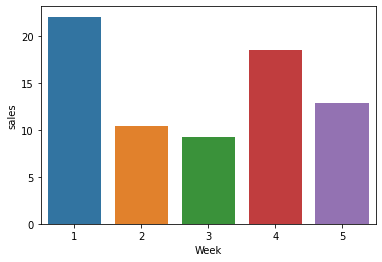

In [ ]:
sns.barplot(data=df[0:5], x='Week', y='sales')

<h2>Amount used in various Marketing Channels Vs Sales</h2>

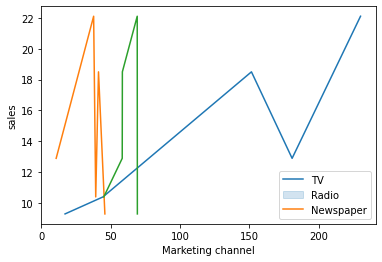

In [ ]:
sns.lineplot(x="TV", y="sales", data=df[0:5],legend='full')
sns.lineplot(x="radio", y="sales", data=df[0:5],legend='full')
sns.lineplot(x="newspaper", y="sales", data=df[0:5],legend='full')
plt.legend(labels=['TV', 'Radio', 'Newspaper'])
plt.xlabel('Marketing channel')
plt.show()

<h2> Understandin distributions of variables </h2>

<Axes: ylabel='Density'>

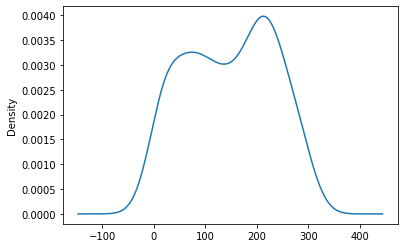

In [ ]:
df["TV"].plot.kde()

<Axes: ylabel='Density'>

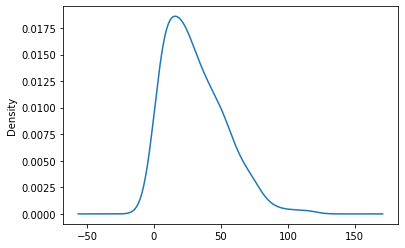

In [ ]:
df["newspaper"].plot.kde()

<Axes: ylabel='Density'>

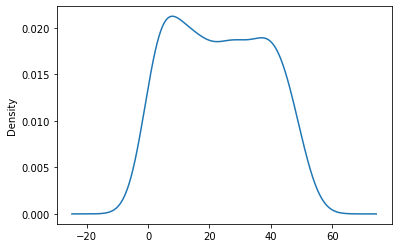

In [ ]:
df["radio"].plot.kde()

<Axes: ylabel='Density'>

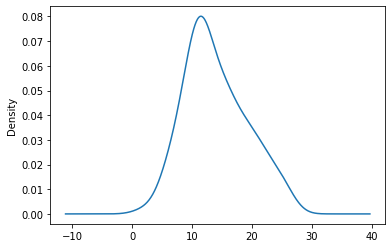

In [ ]:
df["sales"].plot.kde()

<h2> Understanding relationship between dependent variable and independent variable </h2>

In [ ]:
df[["TV","radio","newspaper","sales"]].corr()["sales"]

TV           0.782224
radio        0.576223
newspaper    0.228299
sales        1.000000
Name: sales, dtype: float64

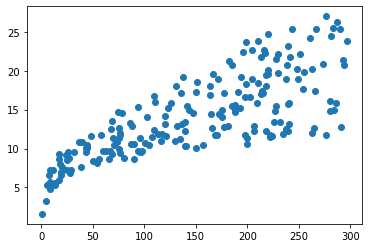

In [ ]:
plt.scatter(df["TV"],df["sales"])

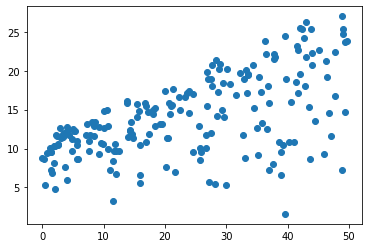

In [ ]:
plt.scatter(df["radio"],df["sales"])

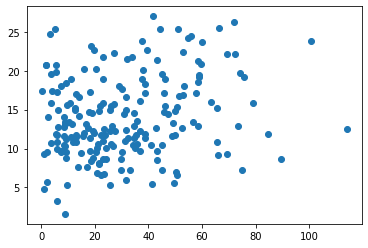

In [ ]:
plt.scatter(df["newspaper"],df["sales"])

### Inference:
  1. TV and Sales are highly correlated increasing the budget of TV increases the overall sales.
  2. Radio and NEwspaper also positively correlated which indicates overall increase in them increases amount of sales.


<h2>Detecting Multicollinearity using VIF</h2>

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
df1 = df[['TV','radio','newspaper']]
vif_data["feature"] = ['TV','radio','newspaper']
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df1.values, i)
                          for i in range(len(df1.columns))]
  
print(vif_data)

     feature       VIF
0         TV  2.486772
1      radio  3.285462
2  newspaper  3.055245


<h3>Inference: </h3>VIF does not exceed 5 which means all media variables do not have a big multicollinearity issue</h3>

# Baseline Model [Linear Regression without any Feature Engineering]

 Goal: Sales = f(TV) + g(Radio) + h(Banners) + Base

=> The sales are just the sum of some function that only depends on the TV spendings, another function that only depends on radio spendings, another function that only depends on web banner spendings, and a (constant) baseline.

=> Models such as random forests, gradient boosting, or (plain and simple feed-forward) neural networks are not suitable here, as we cannot get such a decomposition out of them.

=>A candidate that gives us an additive contribution for each channel is an old friend — linear regression, the simplest representative of additive models!



In [ ]:
df.set_index("Week",inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [ ]:
X = df.drop(columns=['sales'])
y = df['sales']

lr = LinearRegression()

print(cross_val_score(lr, X, y, cv=TimeSeriesSplit()))


[0.90999729 0.89481084 0.83878409 0.90256297 0.90321822]


In [ ]:
lr.fit(X, y) # refit the model with the complete dataset

print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)


Coefficients: [ 0.04576465  0.18853002 -0.00103749]
Intercept: 2.938889369459412


### Sales = 0.0457TV + 0.18853Radio - 0.00103749Newspaper  + 2.93889 

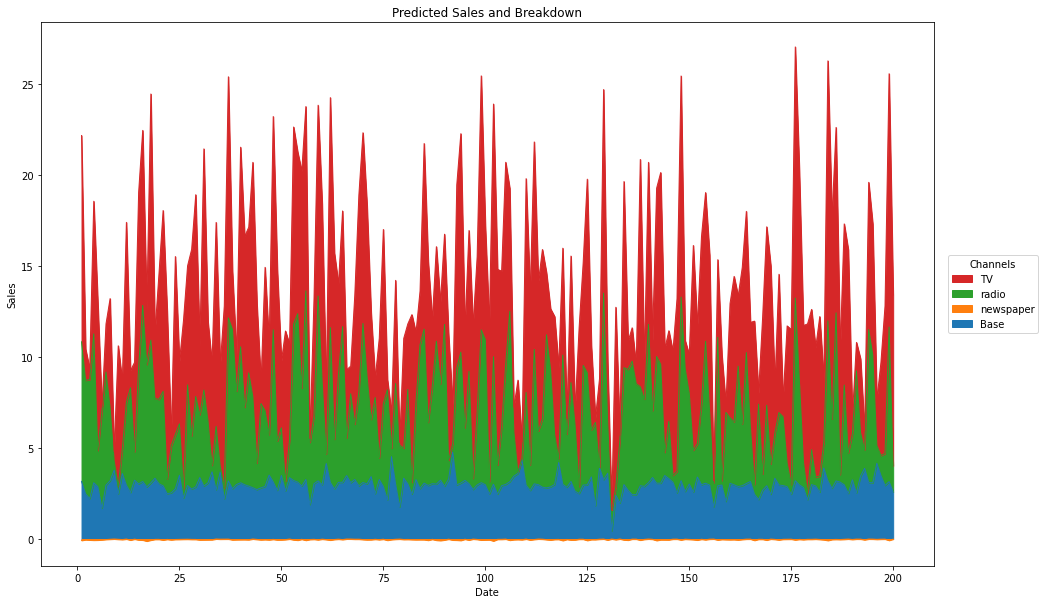

In [ ]:
weights = pd.Series(
    lr.coef_,
    index=X.columns
)

base = lr.intercept_

unadj_contributions = X.mul(weights).assign(Base=base)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    ) # contains all contributions for each day

ax = (adj_contributions[['Base','newspaper', 'radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

### Computing the Return on Investment (ROI)
channel_ROI = Sales from the channel / channel spendings



In [ ]:
sales_from_tv = adj_contributions['TV'].sum()
spendings_on_tv = df['TV'].sum()
tv_roi = sales_from_tv / spendings_on_tv

sales_from_radio = adj_contributions['radio'].sum()
spendings_on_radio = df['radio'].sum()
radio_roi = sales_from_radio / spendings_on_radio

sales_from_newspaper = adj_contributions['newspaper'].sum()
spendings_on_newspaper = df['newspaper'].sum()
newspaper_roi = sales_from_newspaper / spendings_on_newspaper

print("--------------------------------")
print("TV ROI : ",tv_roi)
print("Radio ROI : ",radio_roi)
print("News paper ROI : ",newspaper_roi)
print("--------------------------------")

--------------------------------
TV ROI :  0.04593463673703157
Radio ROI :  0.18590559079877791
News paper ROI :  -0.0010414869255911193
--------------------------------


### Problems With This Simple Approach
While the above approach seems reasonable, it has certain shortcomings that we have to address:
<p>
1. The performance could be better. Sometimes, there is nothing we can do about bad performance because it depends on the data a lot, but we should try our best anyway.<br>
2. Even more severe: The model itself definitely does not reflect reality. According to the linear formula, we can drive sales as high as we want by spending more and more money on advertising. Since the banners have a high coefficient of 1.23, for each 1 € we spend in this channel we generate 1.23 € additional sales. Repeat for infinite money, customers will hate this trick!<br>
3. Optimizing becomes trivial and unrealistic as well. To maximize sales, we would now put all the money into the web banners channel because it has the highest coefficient. We would abandon TV and radio advertising altogether which may be not the right thing to do if the company wants to retain its awareness among people.
</p>

### Fixing the Problems
To circumvent these problems, we can do some clever feature engineering that allows us to incorporate some marketing domain knowledge into the model. 

### Advertising Adstock
This feature engineering that we will do is a crucial component called advertising adstock, a term coined by Simon Broadbent [1]. It is a fancy word that encapsulates two simple concepts:

We assume that the more money you spend on advertising, the higher your sales get. However, the increase gets weaker the more we spend. For example, increasing the TV spends from 0 € to 100,000 € increases our sales a lot, but increasing it from 100,000,000 € to 100,100,000 € does not do that much anymore. This is called a <b>saturation effect or the effect of diminishing returns.</b><br>
If you spend money on advertising week T, often people will not immediately buy your product, but a few (let us say x) weeks later. This is because the product might be expensive, and people want to think about it carefully or compare it to similar products from other companies. Whatever the reason might be, the sale in week T + x is partially caused by the advertising you played in week T, so it should also get some credits. <b>This is called the carry-over or lagged effect.</b>

### Creating Saturating effect
We want to create a transformation (=mathematical function) with the following properties:

If the spendings are 0, the saturated spendings are also 0.<br>
The transformation is monotonically increasing, i.e. the higher the input spendings, the higher the saturated output spendings.<br>
The saturated values do not grow to infinity. Instead, they are upper bounded by some number, let us say 1.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

### Creating a Carry-Over Effect


In [ ]:
from scipy.signal import convolve2d
import numpy as np

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

### Model Building

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['radio']),
     ('banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['newspaper']),
    ],
    remainder='passthrough'
)

model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [ ]:
model.fit(X, y)

print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

-797.9112251129186


In [ ]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

tuned_model = OptunaSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__tv_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__tv_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__radio_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__radio_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__radio_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__banners_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__banners_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__banners_pipe__saturation__a': FloatDistribution(0, 0.01),
    },
    n_trials=100,
    cv=TimeSeriesSplit(),
    random_state=0
)

<ipython-input-95-c507f4b0a62b>:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tuned_model = OptunaSearchCV(


In [ ]:
print(cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit()).mean())


In [ ]:
tuned_model.fit(X, y)

In [ ]:
print(tuned_model.best_params_)
print(tuned_model.best_estimator_.named_steps['regression'].coef_)
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)

{'adstock__tv_pipe__carryover__strength': 0.09689392815107761, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005517434591464699, 'adstock__radio_pipe__carryover__strength': 0.002237512276348129, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00580509716316905, 'adstock__banners_pipe__carryover__strength': 0.9635415797792197, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.00380779180049012}
[17.17942998 38.55574398 -1.20982963]
0.944931882517654


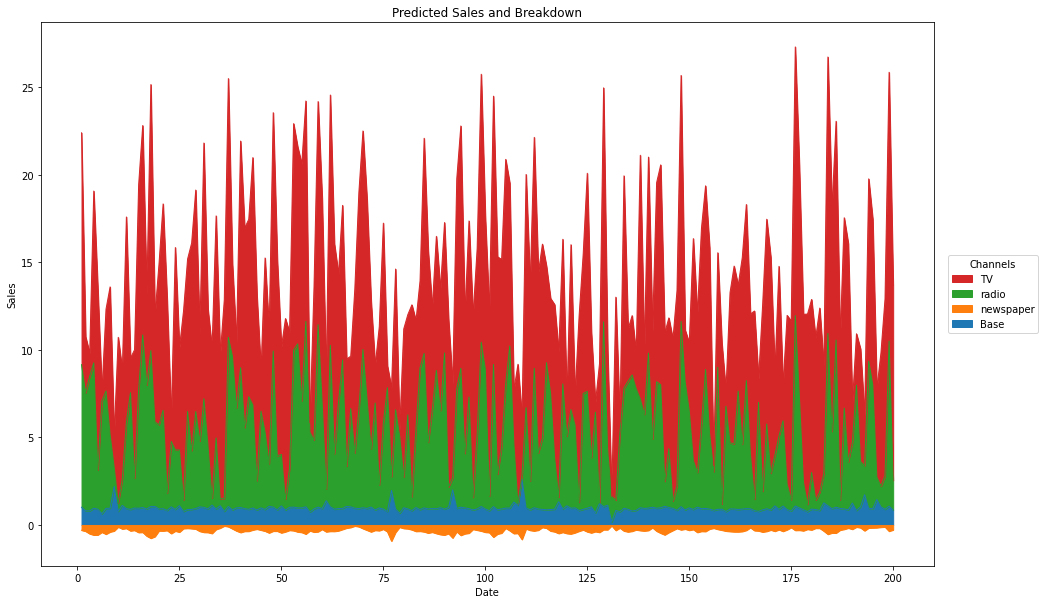

In [ ]:
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)

weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)

base = tuned_model.best_estimator_.named_steps['regression'].intercept_

unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions[['Base', 'newspaper', 'radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)